# Генерация и отбор признаков

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 75)

from datetime import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller

from tsfresh.utilities.dataframe_functions import make_forecasting_frame, impute
from tsfresh import extract_features, select_features

from sklearn.feature_selection import mutual_info_regression

In [2]:
dataset_per_week = pd.read_csv('../data/processed/dataset_per_week.csv', parse_dates=True, index_col=0)
dataset_per_week.shape

list_of_columns = dataset_per_week.columns.copy()

## Ручная генерация признаков и их отбор через анализ корреляции Пирсона/Спирмена

In [ ]:
# Код для ручной генерации признаков использовался прежде, чем использовать библиотеку tsfresh

# for j in list_of_columns:
#     for i in ['mean_4', 'mean_9', 'mean_13', 'mean_26', 'mean_52']:
#         dataset_per_week[j+'_'+i] = dataset_per_week[j].rolling(int(i.split('_')[-1]), min_periods=1).mean()
#     for i in ['shift_1', 'shift_2', 'shift_4', 'shift_9', 'shift_13']:
#         dataset_per_week[j+'_'+i] = dataset_per_week[j].shift(int(i.split('_')[-1]))
#     for i in ['std_4', 'std_9', 'std_13', 'std_26']:
#         dataset_per_week[j+'_'+i] = dataset_per_week[j].rolling(int(i.split('_')[-1]), min_periods=1).std()
#     for i in [1,2,4,9,13]:
#         dataset_per_week[j+'_increment_by_shift_'+str(i)] = dataset_per_week[j]-dataset_per_week[j+'_shift_'+str(i)]
#     for i in [4,9,13,26]:
#         dataset_per_week[j+'_increment_by_mean_'+str(i)] = dataset_per_week[j]-dataset_per_week[j+'_mean_'+str(i)]

# dataset_per_week.shape
# sns.heatmap(dataset_per_week.isna())

# # Отрежем вверх
# dataset_per_week = dataset_per_week.iloc[13:]
# # Отбросим плохие колонки
# cols = dataset_per_week.isna().sum()[dataset_per_week.isna().sum()>0].index.values.copy()
# dataset_per_week = dataset_per_week.drop(columns=cols)

In [ ]:
# Код для ручной селекции признаков использовался прежде, чем использовать библиотеку tsfresh

# dataset_per_week.columns
# candidates = dataset_per_week.corr(method='spearman').lme_price_smooth.sort_values()[-600:]
# candidates = candidates.sort_values(ascending=False).index.values
# candidates

# correlation_matrix = dataset_per_week[candidates].corr(method='spearman')
# correlation_matrix
# candidates = candidates[1:]


# def select(candidates, corr_matrix):
#     features = list(candidates.copy())
#     l = len(candidates)
#     for i in range(l):
#         for j in range(i+1,l):
#             if corr_matrix[candidates[i]][candidates[j]]>0.75:
#                 if corr_matrix['lme_price_smooth'][candidates[i]] > corr_matrix['lme_price_smooth'][candidates[j]]:
#                     try:
#                         features.remove(candidates[j])
#                     except:
#                         pass
#                 else:
#                     try:
#                         features.remove(candidates[i])
#                     except:
#                         pass
#     return features

# features = select(candidates=candidates, corr_matrix=correlation_matrix)
# len(features)

# dataset_per_week['target_1'] = dataset_per_week.lme_price_smooth.diff(periods=1)
# dataset_per_week['target_2'] = dataset_per_week.lme_price_smooth.diff(periods=2)
# dataset_per_week['target_3'] = dataset_per_week.lme_price_smooth.diff(periods=3)
# dataset_per_week['target_4'] = dataset_per_week.lme_price_smooth.diff(periods=4)
# features.extend(["covid", "after_feb", "lme_price_smooth", "target_1", "target_2", "target_3", "target_4"])
# final_df = dataset_per_week[features]

## Библиотека TSfresh, генерация признаков

In [3]:
y = dataset_per_week[['lme_price_smooth']].copy()
y["lme_price_smooth"] = y.lme_price_smooth.shift(-4) # отбор признаков происходит, ориентируясь на смещенный таргет
y = y[1:-4] # слайс с 1, так как после обработки данных алгоритмами из библиотеки tsfresh возникнет смещение на 1 дату
y = y.lme_price_smooth # переход к pd.Series

Нижеприведенный код осуществляет генерацию и селекцию признаков по анализу прошедших 2, 4, 9, 12 и 26 недель относительно текущей даты

In [4]:
extracted_relevant_features = pd.DataFrame(index=pd.date_range('2018-03-11', '2023-09-24', freq='W'))

In [ ]:
%%time
extracted_relevant_features = pd.DataFrame(index=pd.date_range('2018-03-11', '2023-09-24', freq='W')) # создание фрейма с индексом 'date'
extracted_relevant_features.index.name = 'date'
for i in list_of_columns: # перебор по названиям экзогенных признаков
    for k in [2,4,9,12,26]: # перебор по 2, 4, 9, 12 и 26 неделям
        series = dataset_per_week[i].copy() # срез по определенному экзогенному признаку
        df_rolled = make_forecasting_frame(series, kind='price', max_timeshift=k, rolling_direction=1) # генерация временных рядов 
        df_features = extract_features(df_rolled[0].drop(columns=['kind']), column_id="id", column_sort="time") # генерация признаков
        suf = '_'+i+'_'+str(k)+'_weeks' 
        df_features = df_features.add_suffix(suf) # название колонок по признаку и окну 2, 4, 9, 12 и 26 недель 
        df_features.reset_index(inplace=True)
        df_features.drop(columns=['level_0'], inplace=True)
        df_features.rename(columns={'level_1': 'date'}, inplace=True) 
        df_features.set_index('date', inplace=True) # сброс мультииндекса и назначение нового
        df_features = df_features.dropna(axis=1) # сброс всех колонок с Nan
        df_features = df_features[:-4] # срез последних 4 точек, так как таргет смещен на 4 (прогноз на месяц вперед)
        df_selected_features = select_features(df_features, y) # селекция признаков
        extracted_relevant_features = extracted_relevant_features.join(df_features, on='date', how='left') # join
        #print(f"Joined succesfully! Columns count is {extracted_relevant_features.shape[1]}")
        del series
        del df_rolled
        del df_features
        del df_selected_features
    print("Created features for", i)

Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  8.90it/s]


Created features for lme_change


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  8.34it/s]


Created features for baltic_dry_index


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  9.16it/s]


Created features for bloomberg_metals_price


Feature Extraction: 100%|██████████| 20/20 [00:03<00:00,  6.37it/s]


Created features for bloomberg_metals_change


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  7.59it/s]


Created features for ftse_index


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  7.41it/s]


Created features for ftse_index_change


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  7.34it/s]


Created features for sp_metals_price


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  7.92it/s]


Created features for sp_metals_change


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  7.89it/s]


Created features for mosexchange_value


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  7.98it/s]


Created features for alcoa_price


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  7.41it/s]


Created features for chalco_price


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  7.54it/s]


Created features for chalco_adj


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  7.24it/s]


Created features for hongqiao_price


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  7.20it/s]


Created features for hongqiao_adj


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  7.17it/s]


Created features for kaiser_price


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  6.94it/s]


Created features for norsk_hydro_price


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  7.76it/s]


Created features for norsk_hydro_adj


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  7.07it/s]


Created features for rual_price


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  6.88it/s]


Created features for rual_price_change


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  7.01it/s]


Created features for rub_to_cny


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  6.86it/s]


Created features for rub_to_cny_change


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  6.74it/s]


Created features for usd_to_hkd


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  7.34it/s]


Created features for usd_to_clp


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  7.52it/s]


Created features for usd_to_cny


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  7.40it/s]


Created features for dxy_rate


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  7.26it/s]


Created features for usd_to_eur


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  7.29it/s]


Created features for usd_to_jpy


Feature Extraction: 100%|██████████| 20/20 [00:03<00:00,  6.29it/s]


Created features for usd_to_rub


Feature Extraction: 100%|██████████| 20/20 [00:03<00:00,  6.46it/s]


Created features for china_index


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  6.69it/s]


Created features for shanghai_index


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  7.28it/s]


Created features for export_australia_value


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


Created features for import_australia_value


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  7.96it/s]


Created features for australia_inflation


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  7.69it/s]


Created features for australia_pmi


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  7.38it/s]


Created features for export_brazil_value


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  7.36it/s]


Created features for import_brazil_value


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  7.22it/s]


Created features for brazil_inflation


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  7.80it/s]


Created features for brazil_pmi


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  6.72it/s]


Created features for china_gdp_increment_value


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  8.28it/s]


Created features for export_china_value


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  7.22it/s]


Created features for china_inflation_value


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  7.32it/s]


Created features for china_pmi1_value


Feature Extraction: 100%|██████████| 20/20 [00:03<00:00,  6.66it/s]


Created features for china_pmi2_value


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]


Created features for eu_inflation_value


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  7.18it/s]


Created features for guinea_inflation


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  7.39it/s]


Created features for usa_gdp_increment_value


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  8.10it/s]


Created features for export_usa_value


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  7.54it/s]


Created features for import_usa_value


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  8.05it/s]


Created features for usa_inflation_value


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  7.10it/s]


Created features for usa_pmi_value


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  7.55it/s]


Created features for usa_interest_rate_value


Feature Extraction: 100%|██████████| 20/20 [00:03<00:00,  6.61it/s]


Created features for log10_lme_volume


Feature Extraction: 100%|██████████| 20/20 [00:03<00:00,  6.38it/s]


Created features for log10_alcoa_volume


Feature Extraction: 100%|██████████| 20/20 [00:03<00:00,  5.62it/s]


Created features for log10_hongqiao_volume


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  7.01it/s]


Created features for log10_kaiser_volume


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  7.24it/s]


Created features for log10_rual_volume


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  7.12it/s]


Created features for log10_chalco_volume


Feature Extraction: 100%|██████████| 20/20 [00:03<00:00,  6.11it/s]


Created features for log10_norsk_hydro_volume


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  7.04it/s]


Created features for lme_price_smooth
CPU times: user 3min 49s, sys: 1min 5s, total: 4min 55s
Wall time: 23min 48s


In [ ]:
extracted_relevant_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 290 entries, 2018-03-11 to 2023-09-24
Freq: W-SUN
Columns: 64219 entries, value__variance_larger_than_standard_deviation_lme_change_2_weeks to value__lempel_ziv_complexity__bins_100_lme_price_smooth_26_weeks
dtypes: float64(64219)
memory usage: 142.1 MB


In [ ]:
extracted_relevant_features.to_csv('../data/processed/extracted_relevant_features.csv')

In [5]:
extracted_relevant_features = pd.read_csv('../data/processed/extracted_relevant_features.csv', parse_dates=True, index_col=0)

### Удалим признаки с нулевым среднеквадратичным отклоеннием

In [6]:
mask = extracted_relevant_features.std()!=0
extracted_relevant_features = extracted_relevant_features[extracted_relevant_features.std()[mask].index]

In [7]:
extracted_relevant_features.shape

(290, 45478)

### Объединим нагенерированные признаки с исходными экзогенными признаками и таргетом

In [8]:
extracted_relevant_features = extracted_relevant_features.join(dataset_per_week, on='date', how='left')
extracted_relevant_features.shape

(290, 45537)

### Признаков по-прежнему очень много, попробуем применить Mutual info из Sklearn

In [9]:
y_ = y.values
x_ = extracted_relevant_features.values
feature_names = extracted_relevant_features.columns.to_list()

In [10]:
len(feature_names)

45537

In [11]:
mi_scores = mutual_info_regression(x_, y_, n_neighbors=5)

threshold = np.quantile(mi_scores, 0.9)
selected_features = np.array(feature_names)[mi_scores > threshold]

print(f"Number of selected features: {len(selected_features)}")

Number of selected features: 4554


In [88]:
extracted_relevant_features = extracted_relevant_features.loc[:, selected_features].copy()

In [16]:
extracted_relevant_features['target'] = y.values

In [18]:
# features and target after variance threshold and mutual info
extracted_relevant_features.to_csv('../data/processed/data_after_vt_mi.csv')

In [ ]:
extracted_relevant_features = pd.read_csv('../data/processed/features_after_vt_mi.csv', parse_dates=True, index_col=0)

In [19]:
# Введем период после повышения ставки ФРС
extracted_relevant_features['after_feb']=np.where((extracted_relevant_features.index>='2022-03-01')&(extracted_relevant_features.index<='2022-09-01'), 1, 0)

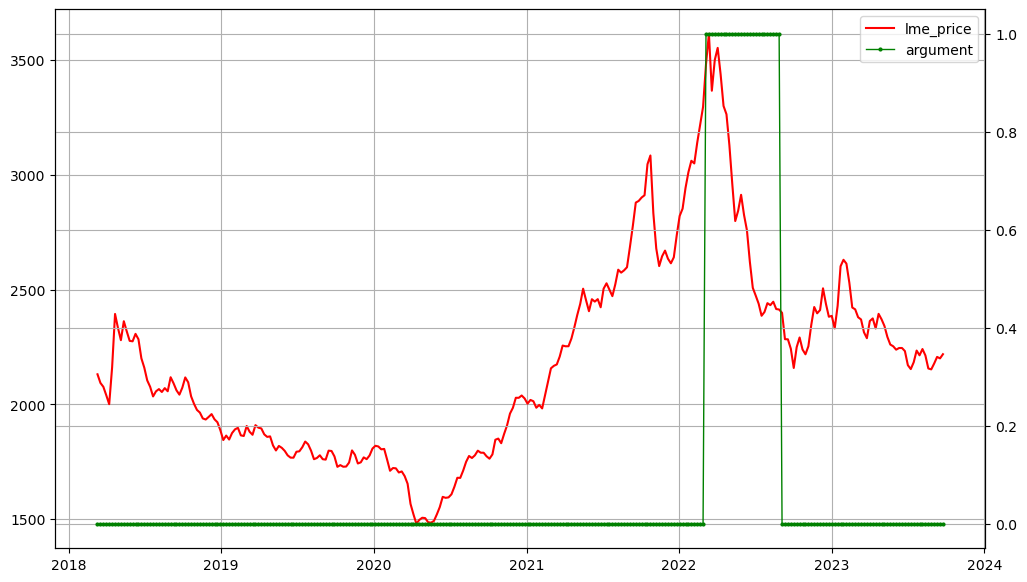

In [20]:
fig, ax = plt.subplots(figsize=(12, 7))
l1, = ax.plot(extracted_relevant_features.index.values, extracted_relevant_features.lme_price_smooth.values, color='r')
ax1 = ax.twinx()
l2, = ax1.plot(extracted_relevant_features.index.values, extracted_relevant_features.after_feb, color='g', marker='o', linewidth=1, markersize=2)
ax1.legend([l1,l2],['lme_price', 'argument'])
#ax1.set_ylim([0,1e6])
ax.grid(True)
ax1.grid(True)

## Feature importance

In [21]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

In [22]:
X = extracted_relevant_features.drop(columns=['target']).values
y = extracted_relevant_features['target'].values

In [23]:
X_full_train, X_full_test, y_train, y_test = train_test_split(X, y, test_size=.1, shuffle=False)
X_train, X_valid, y_train, y_valid = train_test_split(X_full_train, y_train, test_size=.1, shuffle=False)


In [24]:
model = CatBoostRegressor(eval_metric = "MAPE",
                          task_type = "CPU",
                          thread_count = 4,
                          random_state=42)

model.fit(X=X_train,
          y=y_train,
          eval_set=(X_valid, y_valid),
          early_stopping_rounds=20)

Learning rate set to 0.040538
0:	learn: 0.1740605	test: 0.0905273	best: 0.0905273 (0)	total: 2.05s	remaining: 34m 10s
1:	learn: 0.1680168	test: 0.0873371	best: 0.0873371 (1)	total: 3.72s	remaining: 30m 56s
2:	learn: 0.1630823	test: 0.0863773	best: 0.0863773 (2)	total: 5.46s	remaining: 30m 13s
3:	learn: 0.1579105	test: 0.0854027	best: 0.0854027 (3)	total: 7.34s	remaining: 30m 27s
4:	learn: 0.1533224	test: 0.0793271	best: 0.0793271 (4)	total: 9.13s	remaining: 30m 16s
5:	learn: 0.1488141	test: 0.0701441	best: 0.0701441 (5)	total: 10.8s	remaining: 29m 55s
6:	learn: 0.1449674	test: 0.0690339	best: 0.0690339 (6)	total: 12.5s	remaining: 29m 38s
7:	learn: 0.1404031	test: 0.0674112	best: 0.0674112 (7)	total: 14.3s	remaining: 29m 29s
8:	learn: 0.1361229	test: 0.0663464	best: 0.0663464 (8)	total: 16s	remaining: 29m 22s
9:	learn: 0.1324087	test: 0.0647278	best: 0.0647278 (9)	total: 17.7s	remaining: 29m 14s
10:	learn: 0.1286181	test: 0.0607933	best: 0.0607933 (10)	total: 19.5s	remaining: 29m 15s
11

In [27]:
prediction = model.predict(X_full_test)
mean_absolute_percentage_error(y_test, prediction)

0.02301999759923596

In [30]:
list_of_features = extracted_relevant_features.drop(columns=['target']).columns.to_list()

importances = model.feature_importances_

df = pd.DataFrame(data={"importances":importances,
                        "feature_names":list_of_features})

In [31]:
df.sort_values(by="importances", ascending=False, inplace=True)
df = df[df.importances > 0]
df.reset_index(drop=True, inplace=True)

In [32]:
df

,importances,feature_names
0,6.383953,value__c3__lag_3_norsk_hydro_price_12_weeks
1,5.192949,value__quantile__q_0.3_china_index_26_weeks
2,4.083292,"value__change_quantiles__f_agg_""mean""__isabs_T..."
3,2.876058,value__sum_values_chalco_adj_12_weeks
4,2.818276,value__quantile__q_0.9_rual_price_26_weeks
...,...,...
255,0.000346,value__sum_of_reoccurring_data_points_export_c...
256,0.000280,value__index_mass_quantile__q_0.9_brazil_pmi_1...
257,0.000197,value__symmetry_looking__r_0.8_hongqiao_adj_26...
258,0.000107,"value__change_quantiles__f_agg_""mean""__isabs_F..."


Отрезали множество признаков, значимость которых, по мнению модели, была пренебрежимо мала

In [33]:
df.to_csv("../data/processed/feature_importances_by_catboost.csv")

In [34]:
extracted_relevant_features = extracted_relevant_features.loc[:, df.feature_names]

## Прежде, чем анализировать парную корелляцию, необходимо привести все ряды к стационарному виду (например, продифференцировав все)

In [35]:
diff_relevant_features = extracted_relevant_features.diff(periods=1).copy()
diff_relevant_features = diff_relevant_features[1:]

In [36]:
# Тест Дикки-Фуллера с alpha уровнем значимости
def check_stationarity(ts: list, alpha: float):
    dftest = adfuller(ts)
    adf, pvalue, critical_value = dftest[0], dftest[1], dftest[4]['5%']
    if (pvalue < alpha) and (adf < critical_value):
        #print('The series is stationary')
        return True
    else:
        #print('The series is NOT stationary')
        return False

In [37]:
not_stationary = list()
for i in diff_relevant_features.columns:
    if check_stationarity(diff_relevant_features[i], 0.05) is False:
        not_stationary.append(i)

/Users/epsilon/miniconda3/envs/ml/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/epsilon/miniconda3/envs/ml/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/epsilon/miniconda3/envs/ml/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/epsilon/miniconda3/envs/ml/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/epsilon/miniconda3/envs/ml/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:956: R

In [38]:
len(not_stationary)

14

In [42]:
diff_relevant_features.drop(columns=not_stationary, inplace=True)

In [43]:
diff_relevant_features['target'] = y[1:]

Для анализа парной корелляции удобнее создать словарь, в котором ключом выступает признак  
Не забудем удалить признаки, которые оказались нестационарны даже после дифференцирования

In [44]:
key_list = df.feature_names.values
value_list = df.importances.values

importances_dict = dict(zip(key_list, value_list))

for i in not_stationary:
    del importances_dict[i]

In [45]:
corr_matrix = diff_relevant_features.corr()

Топорный алгоритм отбора признаков во избежание мультиколлинеарности

In [46]:
def select(candidates, corr_matrix):
    features = list(candidates.copy())
    l = len(candidates)
    for i in range(l):
        for j in range(i+1,l):
            if corr_matrix[candidates[i]][candidates[j]]>0.75:
                if importances_dict[candidates[i]]>=importances_dict[candidates[j]]:
                    try:
                        features.remove(candidates[j])
                    except:
                        pass
                else:
                    try:
                        features.remove(candidates[i])
                    except:
                        pass
    return features

In [47]:
new_candidates = select(candidates=list(importances_dict.keys()), corr_matrix=corr_matrix)
len(new_candidates)

221

Вернемся к недифференцированному набору данных

In [48]:
extracted_relevant_features = extracted_relevant_features.loc[:, new_candidates]
extracted_relevant_features['target'] = y

## Permutation importance

In [52]:
X = extracted_relevant_features.drop(columns=['target']).values
y = extracted_relevant_features['target'].values

In [53]:
X_full_train, X_full_test, y_train, y_test = train_test_split(X, y, test_size=.1, shuffle=False)
X_train, X_valid, y_train, y_valid = train_test_split(X_full_train, y_train, test_size=.1, shuffle=False)

In [54]:
X_train.shape, X_valid.shape, X_full_test.shape

((234, 221), (27, 221), (29, 221))

In [55]:
model_2 = CatBoostRegressor(eval_metric = "MAPE",
                          task_type = "CPU",
                          thread_count = 4,
                          random_state=42)

model_2.fit(X=X_train,
          y=y_train,
          eval_set=(X_valid, y_valid),
          early_stopping_rounds=20)

Learning rate set to 0.040538
0:	learn: 0.1740378	test: 0.0897648	best: 0.0897648 (0)	total: 11.3ms	remaining: 11.3s
1:	learn: 0.1682595	test: 0.0876159	best: 0.0876159 (1)	total: 21.5ms	remaining: 10.7s
2:	learn: 0.1628104	test: 0.0865794	best: 0.0865794 (2)	total: 29.5ms	remaining: 9.82s
3:	learn: 0.1585537	test: 0.0867064	best: 0.0865794 (2)	total: 36.5ms	remaining: 9.08s
4:	learn: 0.1535453	test: 0.0861493	best: 0.0861493 (4)	total: 48.8ms	remaining: 9.71s
5:	learn: 0.1486539	test: 0.0859312	best: 0.0859312 (5)	total: 57ms	remaining: 9.44s
6:	learn: 0.1436166	test: 0.0841853	best: 0.0841853 (6)	total: 63.1ms	remaining: 8.95s
7:	learn: 0.1391720	test: 0.0829290	best: 0.0829290 (7)	total: 69.7ms	remaining: 8.64s
8:	learn: 0.1346607	test: 0.0818086	best: 0.0818086 (8)	total: 77.1ms	remaining: 8.49s
9:	learn: 0.1301389	test: 0.0815402	best: 0.0815402 (9)	total: 83.1ms	remaining: 8.23s
10:	learn: 0.1258182	test: 0.0815123	best: 0.0815123 (10)	total: 88.4ms	remaining: 7.94s
11:	learn: 0.

In [56]:
prediction = model_2.predict(X_full_test)
mean_absolute_percentage_error(y_test, prediction)

0.028120851540894824

In [57]:
from sklearn.inspection import permutation_importance

In [58]:
scoring = ['neg_mean_absolute_percentage_error']
r = permutation_importance(model_2, X_valid, y_valid, n_repeats=100, random_state=42)

In [59]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{extracted_relevant_features.drop(columns=['target']).columns.to_list()[i]} "
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

value__sum_values_chalco_price_2_weeks 0.022 +/- 0.007
value__index_mass_quantile__q_0.4_usa_inflation_value_26_weeks 0.014 +/- 0.004
value__absolute_maximum_usd_to_rub_2_weeks 0.013 +/- 0.005
value__time_reversal_asymmetry_statistic__lag_3_brazil_pmi_26_weeks 0.006 +/- 0.003
value__fft_aggregated__aggtype_"centroid"_log10_norsk_hydro_volume_12_weeks 0.005 +/- 0.002
value__c3__lag_3_norsk_hydro_price_12_weeks 0.003 +/- 0.001
value__time_reversal_asymmetry_statistic__lag_2_export_australia_value_26_weeks 0.002 +/- 0.001


In [63]:
feature_list = ['value__sum_values_chalco_price_2_weeks',
                'value__index_mass_quantile__q_0.4_usa_inflation_value_26_weeks',
                'value__absolute_maximum_usd_to_rub_2_weeks',
                'value__time_reversal_asymmetry_statistic__lag_3_brazil_pmi_26_weeks',
                'value__fft_aggregated__aggtype_"centroid"_log10_norsk_hydro_volume_12_weeks',
                'value__c3__lag_3_norsk_hydro_price_12_weeks',
                'value__time_reversal_asymmetry_statistic__lag_2_export_australia_value_26_weeks',
                'target'
                ]

Проверим работу модели на данном наборе признаков

In [64]:
extracted_relevant_features = extracted_relevant_features.loc[:, feature_list].copy()

In [65]:
X = extracted_relevant_features.drop(columns=['target']).values
y = extracted_relevant_features['target'].values

In [66]:
X_full_train, X_full_test, y_train, y_test = train_test_split(X, y, test_size=.1, shuffle=False)
X_train, X_valid, y_train, y_valid = train_test_split(X_full_train, y_train, test_size=.1, shuffle=False)

In [67]:
X_train.shape, X_valid.shape, X_full_test.shape

((234, 7), (27, 7), (29, 7))

In [68]:
model_3 = CatBoostRegressor(eval_metric = "MAPE",
                          task_type = "CPU",
                          thread_count = 4,
                          random_state=42)

model_3.fit(X=X_train,
          y=y_train,
          eval_set=(X_valid, y_valid),
          early_stopping_rounds=20)

Learning rate set to 0.040538
0:	learn: 0.1736563	test: 0.0894873	best: 0.0894873 (0)	total: 755us	remaining: 755ms
1:	learn: 0.1681732	test: 0.0857463	best: 0.0857463 (1)	total: 1.49ms	remaining: 743ms
2:	learn: 0.1638266	test: 0.0836606	best: 0.0836606 (2)	total: 2.18ms	remaining: 724ms
3:	learn: 0.1591038	test: 0.0792685	best: 0.0792685 (3)	total: 2.76ms	remaining: 687ms
4:	learn: 0.1551063	test: 0.0780381	best: 0.0780381 (4)	total: 3.33ms	remaining: 664ms
5:	learn: 0.1503909	test: 0.0736356	best: 0.0736356 (5)	total: 3.87ms	remaining: 642ms
6:	learn: 0.1454518	test: 0.0722244	best: 0.0722244 (6)	total: 4.43ms	remaining: 629ms
7:	learn: 0.1408804	test: 0.0715570	best: 0.0715570 (7)	total: 5.02ms	remaining: 622ms
8:	learn: 0.1363163	test: 0.0691345	best: 0.0691345 (8)	total: 5.55ms	remaining: 611ms
9:	learn: 0.1321560	test: 0.0671692	best: 0.0671692 (9)	total: 6.04ms	remaining: 598ms
10:	learn: 0.1282680	test: 0.0631744	best: 0.0631744 (10)	total: 6.67ms	remaining: 600ms
11:	learn: 0

In [69]:
prediction = model_3.predict(X_full_test)
mean_absolute_percentage_error(y_test, prediction)

0.13198146053242604

Можно заметить, что метрика качества на отложенной выборке не просто сохранилась, но и улучшилась ввиду исключения шумовых признаков, которые ухудшали метрику

In [73]:
extracted_relevant_features.to_csv('../data/processed/prepared_data.csv')